# 3.3. Jakość podziału: MSE

Jeśli masz już doświadczenie w rozwiązywaniu problemów regresji, np. za pomocą prostego modelu regresji liniowej, to z pewnością metryka **Mean Squared Error** nie jest Ci obca. Zacznijmy może od formalnej definicji:

$$ MSE = \frac{ \sum_{i=0}^{N}{ ( \overline{y_{i}} - y_{i} )^{2} } }{ N } $$

Pozwala ona określić jaka jest średnia odległość wartości zwracanych przez nasz system do wartości oczekiwanych. Przez wykorzystanie kwadratu różnicy, **MSE** zwraca niejako większą uwagę na wartości najbardziej odległe od prawdziwych.

## Podział zbioru danych z wykorzystaniem MSE

Podobnie jak w przypadku klasyfikacji, proces uczenia sprawdza różne możliwości podziału zbioru w aktualnym węźle drzewa. Dzieje się to zarówno na poziomie wyboru najlepszej cechy, jak i jej optymalnej wartości, aby zmaksymalizować wartość *impurity*. Uprościmy sobie trochę to zagadnienie - załóżmy że mamy tylko jedną cechę i chcemy dokonać podziału tylko ze względu na jej wartość. 

Zagadnienie optymalizacji cen jest dość często rozpatrywanym problemem. Kwota jaką musimy zapłacić za dany produkt ma ogromny wpływ na liczbę sprzedanych produktów, a przez to na nasz dochód, jeśli jesteśmy sprzedawcą. Załóżmy że domyślnie nasz produkt kosztuje 20 zł, a nasz zarobek to 30% marży, tj. 6 zł. Jeśli zmniejszymy cenę, to w oczywisty sposób koszta pozostaną niezmienne, a nasza marża spadnie. W takim wypadku spodziewalibyśmy się wzrostu liczby transakcji, co finalnie może przełożyć się na większy zysk, pomimo mniejszej marży. Może się tak dziać tylko do pewnego poziomu, ponieważ popyt na dany towar nie jest nieograniczony. Przeciwnie, zwiększając cenę, możemy uzyskiwać większe marże, jednak liczba zakupionych produktów będzie w granicy spadać do 0. Załóżmy jednak, że jesteśmy w stanie eksperymentować. Załóżmy, że w toku eksperymentu zgromadziliśmy takie informacje i otrzymaliśmy następujące dane (dochód liczymy w okienkach tygodniowych):

In [1]:
import numpy as np
import pandas as pd

In [2]:
price = np.linspace(14, 30, 15)
income = [0.0,
          22.270210334494614,
          61.5656001620554,
          76.31767626268956,
          139.84489205505548,
          196.65351459100881,
          263.50293653807745,
          265.9914199145693,
          237.01894881636946,
          173.14474251125418,
          121.16183867125716,
          60.498814563088466,
          26.97578198428058,
          3.5312918245180143,
          4.932649288597467]
prices_df = pd.DataFrame({
    "price": price,
    "income": income
})
prices_df

,price,income
0,14.000000,0.000000
1,15.142857,22.270210
2,16.285714,61.565600
3,17.428571,76.317676
4,18.571429,139.844892
5,19.714286,196.653515
6,20.857143,263.502937
7,22.000000,265.991420
8,23.142857,237.018949
9,24.285714,173.144743


<Axes: xlabel='price', ylabel='income'>

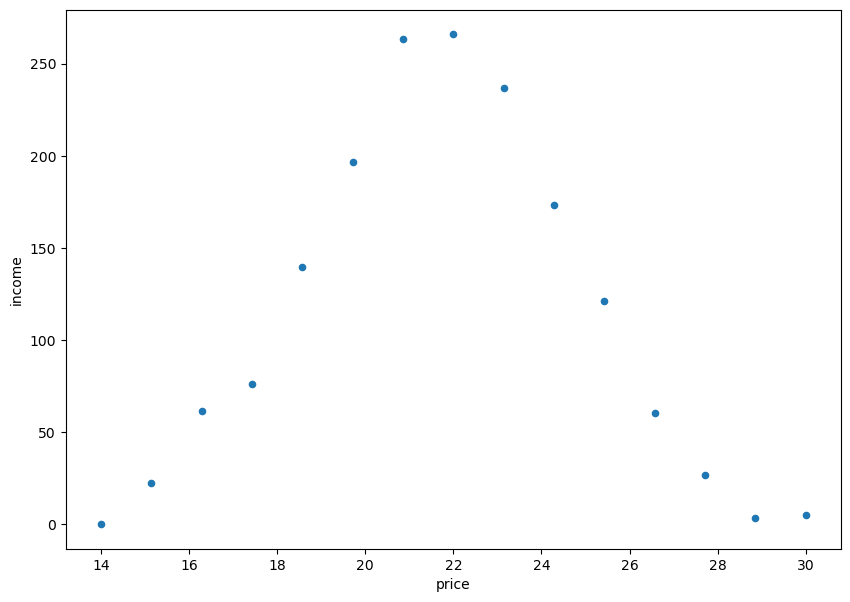

In [3]:
prices_df.plot.scatter(x="price", y="income", figsize=(10,7))

In [4]:
thresholds = prices_df["price"].rolling(2).mean().dropna()
thresholds


1     14.571429
2     15.714286
3     16.857143
4     18.000000
5     19.142857
6     20.285714
7     21.428571
8     22.571429
9     23.714286
10    24.857143
11    26.000000
12    27.142857
13    28.285714
14    29.428571
Name: price, dtype: float64

In [5]:
from sklearn.metrics import mean_squared_error

<Axes: xlabel='threshold'>

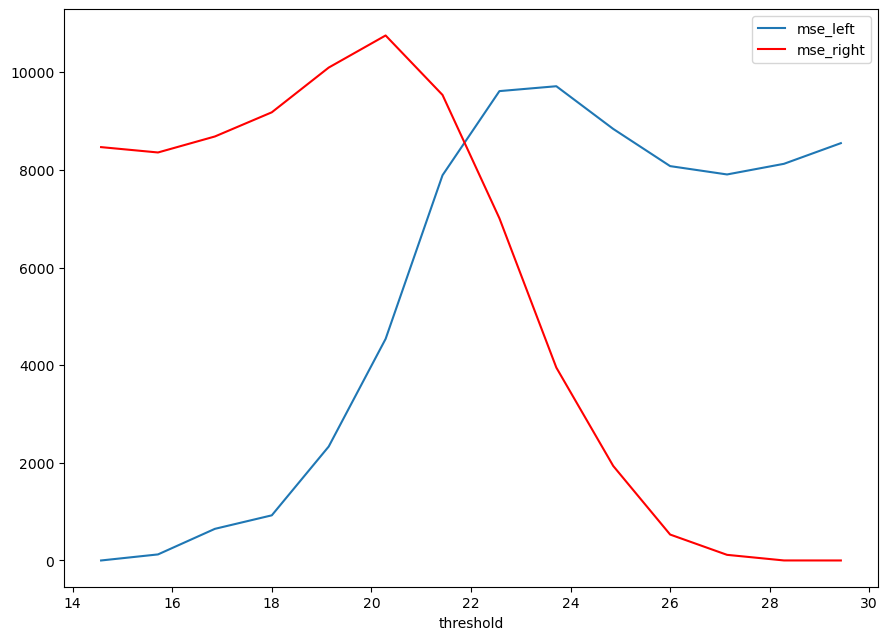

In [6]:
values = []
for threshold in thresholds.dropna():
    df_left = prices_df[prices_df["price"] <= threshold]
    df_right = prices_df[prices_df["price"] > threshold]
    target_left = np.full_like(df_left["income"], 
                               np.mean(df_left["income"]))
    mse_left = mean_squared_error(df_left["income"], 
                                  target_left)
    target_right = np.full_like(df_right["income"], 
                                np.mean(df_right["income"]))
    mse_right = mean_squared_error(df_right["income"], 
                                   target_right)
    values.append([threshold, 
                   df_left.shape[0], df_right.shape[0],
                   mse_left, mse_right])
    
mse_df = pd.DataFrame(values, columns=("threshold", 
                                       "n_left", "n_right", 
                                       "mse_left", "mse_right"))
ax = mse_df.plot(x="threshold", y="mse_left",
                 figsize=(10.5, 7.5))
mse_df.plot(x="threshold", y="mse_right", 
            ax=ax, c="red")

Musimy oczywiście zoptymalizować jeden wyraz, wartość impurity, który wyliczamy jako ważoną sumę dla obu stworzonych podzbiorów:

$$ G(Q, \theta) = \frac{n_{left}}{N_{m}} H(Q_{left}(\theta)) + \frac{n_{right}}{N_{m}} H(Q_{right}(\theta)) $$

In [10]:
impurity = ((mse_df["n_left"] * mse_df["mse_left"]) + mse_df["n_right"] * mse_df["mse_right"]) / 15
mse_df["impurity"] = impurity

In [11]:
impurity

0     7901.200220
1     7258.404820
2     7076.476989
3     6977.610228
4     7507.652484
5     8266.652712
6     8766.726679
7     8397.090869
8     7407.849070
9     6537.456061
10    6064.405334
11    6347.727908
12    7040.597507
13    7977.135558
dtype: float64

<Axes: xlabel='threshold'>

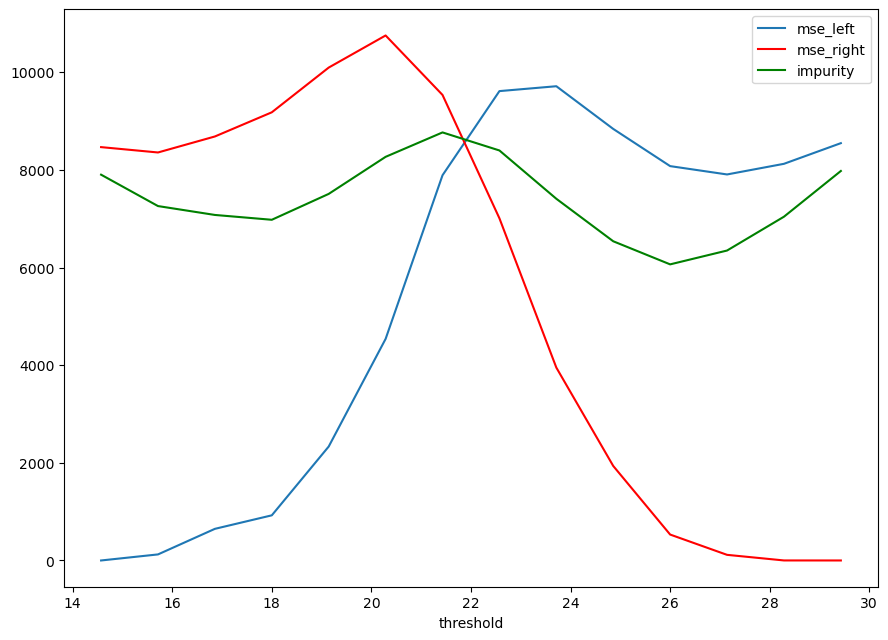

In [12]:
ax = mse_df.plot(x="threshold", y="mse_left",
                 figsize=(10.5, 7.5))
mse_df.plot(x="threshold", y="mse_right", 
            ax=ax, c="red")
mse_df.plot(x="threshold", y="impurity", 
            ax=ax, c="green")

In [13]:
mse_df.nsmallest(n=1, columns="impurity")

,threshold,n_left,n_right,mse_left,mse_right,impurity
10,26.0,11,4,8076.593666,530.887419,6064.405334


In [14]:
import matplotlib.pyplot as plt

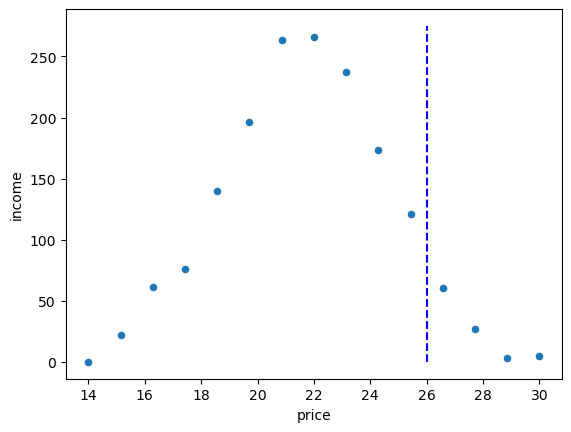

In [15]:
prices_df.plot.scatter(x="price", y="income")
plt.plot([26.0, 26.0], [0, 275], "b--")

In [17]:
left_mean = prices_df[prices_df["price"] <= 26]["income"].mean()
right_mean = prices_df[prices_df["price"] > 26]["income"].mean()

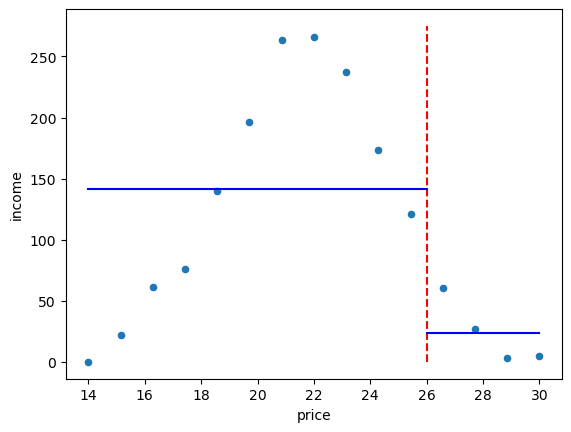

In [18]:
prices_df.plot.scatter(x="price", y="income")
plt.plot([26.0, 26.0], [0, 275], "r--")
plt.plot([14.0, 26.0], [left_mean, left_mean], "b-")
plt.plot([26.0, 30.0], [right_mean, right_mean], "b-")